In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/flowers.zip") as file:
  file.extractall("/content/Data/")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

DATASET_PATH = "/content/Data/flowers/"
TARGET_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
import os
import glob

train_image_path = []
train_image_label = []

# Training Set Images
for folder in os.listdir(DATASET_PATH +"train"):
    for file in os.listdir(os.path.join(DATASET_PATH, "train" , folder)):
        train_image_label.append(folder)
        train_image_path.append(os.path.join(DATASET_PATH,"train",folder, file))

train_df = pd.DataFrame({
    "Image_Path" : train_image_path,
    "Label" : train_image_label
})
print("Total Images in Training Set : ")
print(train_df["Label"].value_counts())

# Test Set Images
print("Total Images in Test Set :",len(glob.glob(DATASET_PATH +"test/*.jpg")))
test_df = pd.read_csv(DATASET_PATH + "Testing_set_flower.csv")
test_df["Image_Path"] = DATASET_PATH + "test/" + test_df["filename"]
test_df.drop("filename", axis=1, inplace=True)

# Exporting both files
train_df.to_csv(DATASET_PATH + "train_df.csv", index=False)
test_df.to_csv(DATASET_PATH + "test_df.csv", index= False)

Total Images in Training Set : 
dandelion    646
tulip        607
daisy        501
rose         497
sunflower    495
Name: Label, dtype: int64
Total Images in Test Set : 924


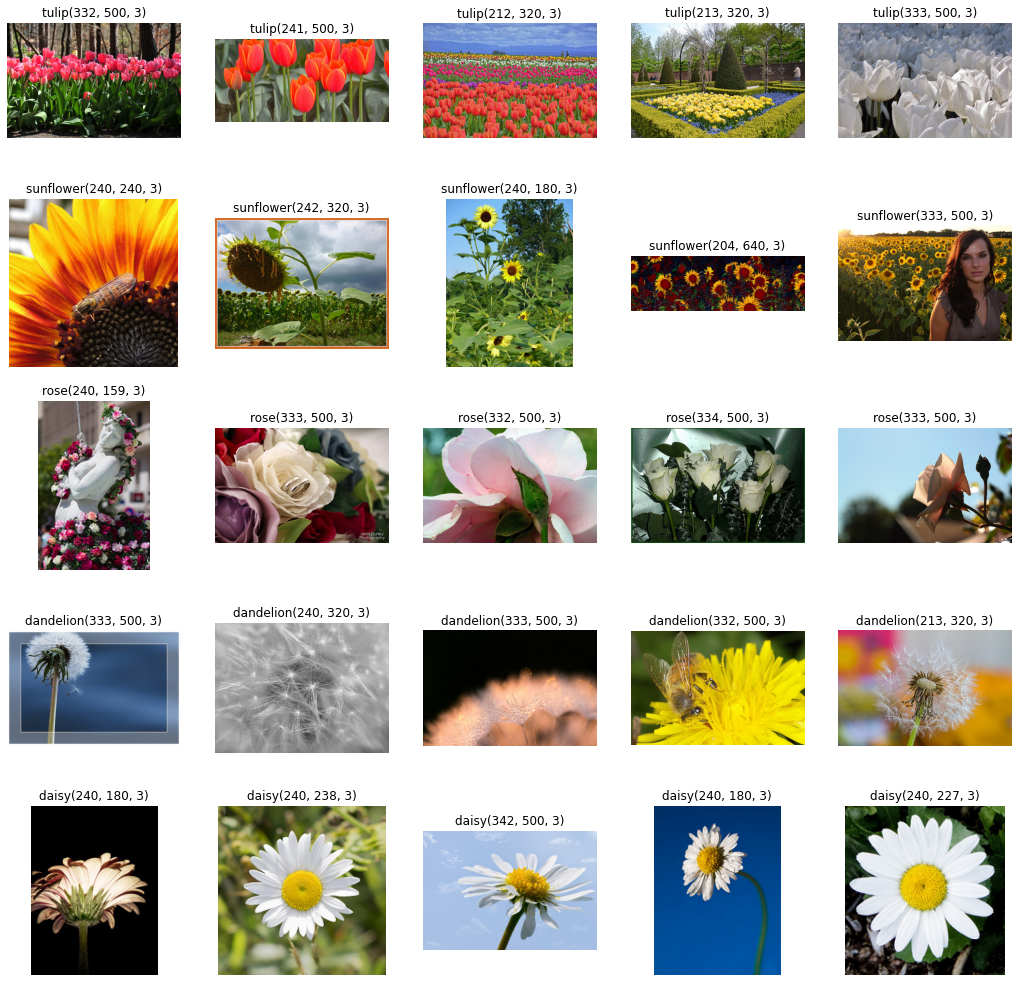

In [ ]:
labels = ['daisy', 'dandelion', 'rose' ,'sunflower' ,'tulip']

sample_images = pd.DataFrame(columns=train_df.columns)
for label in labels:
    temp_df = train_df[train_df["Label"] == label].sample(5)
    sample_images = pd.concat([temp_df,sample_images], sort=False).reset_index(drop=True)


plt.figure(figsize=(18,18))
for i in np.arange(25):
    plt.subplot(5,5,i+1)
    image = plt.imread(sample_images.iloc[i]["Image_Path"])
    plt.axis('off')
    plt.title("{}{}".format(sample_images.iloc[i]["Label"],image.shape))
    plt.imshow(image)
plt.show()

Found 2196 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.
Found 1 validated image filenames belonging to 1 classes.


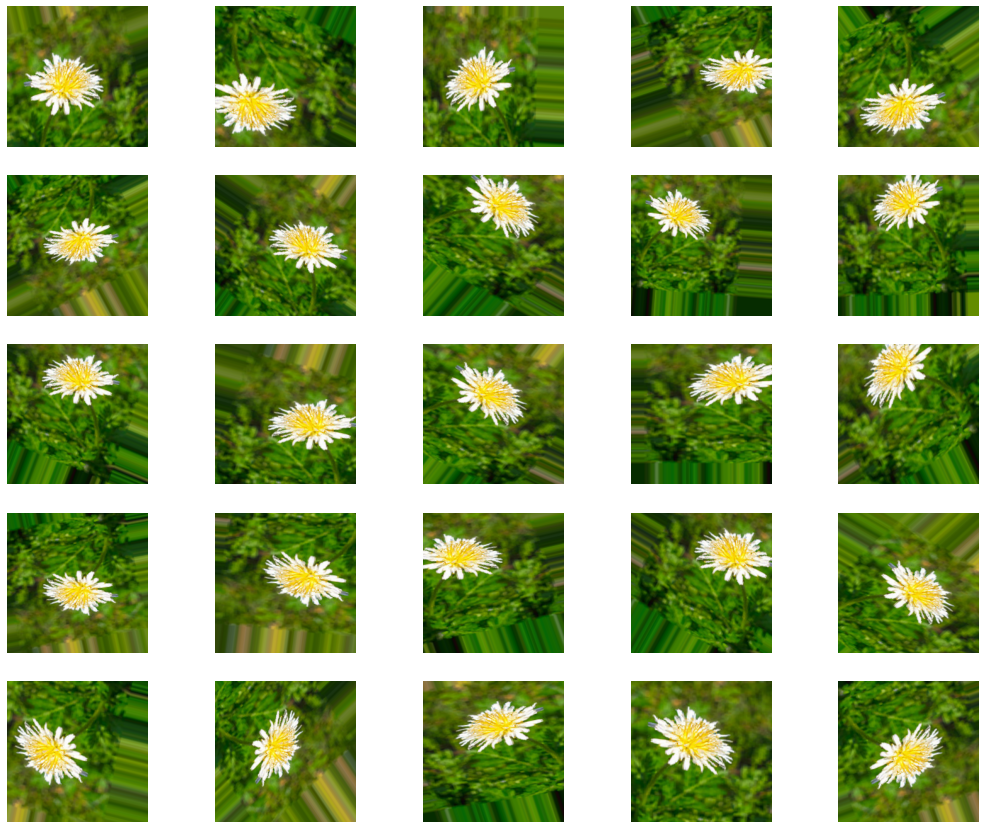

In [64]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import  train_test_split

train_df = pd.read_csv(DATASET_PATH + "train_df.csv")
train_data , validation_data = train_test_split(train_df,test_size=0.20, random_state=101)

# Training Data Generator
training_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, shear_range=0.20,
                                      zoom_range=0.20,width_shift_range=0.20, height_shift_range=0.20, rotation_range=40
                                      )
train_generator = training_datagen.flow_from_dataframe(dataframe=train_data, x_col="Image_Path", y_col="Label",target_size=TARGET_SIZE,
                                                       batch_size=BATCH_SIZE,class_mode="categorical",shuffle=True)
# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_data, x_col="Image_Path", y_col="Label",target_size=TARGET_SIZE,
                                                       batch_size=BATCH_SIZE,class_mode="categorical",shuffle=False)
# Show Sample Image with Augmentation
sample_df = train_data.sample(1).reset_index(drop=True)
sample_generator = training_datagen.flow_from_dataframe(dataframe=sample_df, x_col="Image_Path", y_col="Label",target_size=TARGET_SIZE,
                                                       class_mode="categorical")


TRAIN_STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(validation_data) // BATCH_SIZE

plt.figure(figsize=(18,15))
for i in np.arange(25):
    plt.subplot(5,5,i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break
plt.show()

In [ ]:
import pickle
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

# Defina the Model
pre_trained_model = MobileNet(include_top=False,weights="imagenet",input_shape=(224,224,3))
for layer in pre_trained_model.layers:
    layer.trainable = False
last_output_layer = pre_trained_model.layers[-1].output

x = GlobalAveragePooling2D()(last_output_layer)
x = Dense(units=256,activation="relu")(x)
x = Dropout(rate=0.20)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.20)(x)
x = Dense(units=5, activation='softmax')(x)

model = Model(inputs =pre_trained_model.input, outputs = x)
model.summary()

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0005),metrics=["accuracy"], loss=['categorical_crossentropy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,min_lr=0)
model_checkpoint = ModelCheckpoint(filepath="/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/saved-model-{epoch:02d}-{val_loss:.2f}.h5", 
                                   monitor='val_loss',mode='min',save_best_only=True,verbose=1)

# Fit the Model
history = model.fit_generator(generator=train_generator, validation_data=validation_generator,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH , validation_steps=VAL_STEPS_PER_EPOCH,
                              epochs=30, callbacks=[reduce_lr,model_checkpoint])
model.save("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/model_30_Epochs_1.h5")

with open("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/pickle_30_Epochs_1.pkl", 'wb') as file:
    pickle.dump(history.history, file)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
68/68 [==============================] - 39s 522ms/step - loss: 1.2077 - accuracy: 0.5179 - val_loss: 0.4738 - val_accuracy: 0.8180

Epoch 00001: val_loss improved from inf to 0.47377, saving model to /content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/saved-model-01-0.47.h5
Epoch 2/30
68/68 [==============================] - 35s 512ms/step - loss: 0.5175 - accuracy: 0.8101 - val_loss: 0.3613 - val_accuracy: 0.8787

Epoch 00002: val_loss improved from 0.47377 to 0.36132, saving model to /content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/saved-model-02-0.36.h5
Epoch 3/30
68/68 [==============================] - 35s 509ms/step - loss: 0.4116 - accuracy: 0.8541 - val_loss: 0.3344 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.36132 to 0.33439, saving model to /content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/saved-model-03-0.33.h5
Epoch 4/30
68/68 [==============================] - 35s 510ms/

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/model_30_Epochs_1.h5")
model.compile(optimizer=Adam(learning_rate=0.00005),metrics=["accuracy"], loss=['categorical_crossentropy'])

history = model.fit_generator(generator=train_generator, validation_data=validation_generator,
                              steps_per_epoch=TRAIN_STEPS_PER_EPOCH , validation_steps=VAL_STEPS_PER_EPOCH,
                              epochs=10, callbacks=[reduce_lr, model_checkpoint])
model.save("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/model_40_Epochs_1.h5")

with open("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/pickle_40_Epochs_1.pkl",'wb') as file:
    pickle.dump(history.history, file)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
68/68 [==============================] - 38s 525ms/step - loss: 0.1252 - accuracy: 0.9598 - val_loss: 0.2937 - val_accuracy: 0.9044

Epoch 00001: val_loss did not improve from 0.27980
Epoch 2/10
68/68 [==============================] - 35s 518ms/step - loss: 0.1323 - accuracy: 0.9536 - val_loss: 0.2950 - val_accuracy: 0.9099

Epoch 00002: val_loss did not improve from 0.27980
Epoch 3/10
68/68 [==============================] - 35s 518ms/step - loss: 0.1377 - accuracy: 0.9463 - val_loss: 0.2941 - val_accuracy: 0.9081

Epoch 00003: val_loss did not improve from 0.27980
Epoch 4/10
68/68 [==============================] - 35s 512ms/step - loss: 0.1214 - accuracy: 0.9570 - val_loss: 0.2962 - val_accuracy: 0.9044

Epoch 00004: val_loss did not improve from 0.27980
Epoch 5/10
68/68 [==============================] - 35s 509ms/step - loss: 0.1167 - accuracy: 0.9608 - val_loss: 0.2903 - val_accuracy: 0.9099

Epoch 00005: val_loss did not improve from 0.27980
Epoch 6/10
68/68 [=======

In [61]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_df = pd.read_csv(DATASET_PATH + "test_df.csv")
sample_submission = pd.read_csv(DATASET_PATH + "sample_submission.csv")
model = load_model("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/model_40_Epochs_1.h5")

# Test Generator
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=test_df, x_col="Image_Path",
                                                                        batch_size=BATCH_SIZE, target_size=TARGET_SIZE, shuffle=False,
                                                                        class_mode=None)
prediction = model.predict_generator(test_generator)
sample_submission["prediction"] = np.argmax(prediction, axis=1)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

sample_submission["prediction"] = sample_submission["prediction"].map(labels)
sample_submission.to_csv(DATASET_PATH + "sample_submission_2.csv", index=False)

print(sample_submission)

Found 924 validated image filenames.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


    prediction
0    sunflower
1    sunflower
2    dandelion
3         rose
4         rose
..         ...
919  sunflower
920      tulip
921  dandelion
922  dandelion
923      daisy

[924 rows x 1 columns]


In [42]:
history = []
with open("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/pickle_30_Epochs_1.pkl", 'rb') as file:
    history.append(pickle.load(file))
with open("/content/drive/MyDrive/Computer_Vision_Project/Flower_Image_Classification/pickle_40_Epochs_1.pkl", 'rb') as file:
    history.append(pickle.load(file))

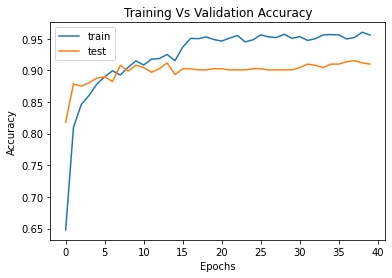

In [60]:
train_accuracy = history[0]["accuracy"] + history[1]["accuracy"]
train_loss = history[0]["loss"] + history[1]["loss"]
val_accuracy = history[0]["val_accuracy"] + history[1]["val_accuracy"]
val_loss = history[0]["val_loss"] + history[1]["val_loss"]

plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title("Training Vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train','test'])
plt.show()

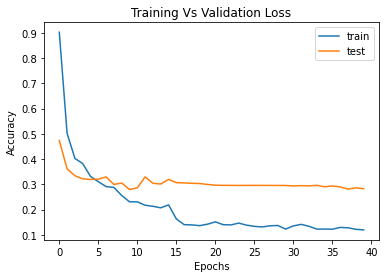

In [59]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Vs Validation Loss")
plt.legend(['train','test'])
plt.show()